In [5]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [6]:
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [7]:
df = pd.read_csv('eng_2020.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)
df = df.drop(columns=["SU Close", "Volume", "Open", "Gas Close", "TSX Close", "High"])
df

,Low,Oil Close,Enb Close,Target Close
Date,,,,
2010-01-05,14.707242,81.769997,14.897686,14.559792
2010-01-06,14.467640,83.180000,14.559792,14.513723
2010-01-07,14.295634,82.660004,14.513723,14.538293
2010-01-08,14.464572,82.750000,14.538293,14.436925
2010-01-11,14.375491,82.519997,14.436925,14.427713
...,...,...,...,...
2020-12-21,40.639999,47.740002,41.549999,41.230000
2020-12-22,41.119999,47.020000,41.230000,41.279999
2020-12-23,41.189999,48.119999,41.279999,41.250000


In [8]:
df_input = df.iloc[:, :-1]
df_output = df[["Enb Close"]]

In [9]:
x_train, x_test, y_train, y_test = train_test_split(df_input, df_output, test_size=0.3, random_state=42, shuffle= False)

In [10]:
x_train.shape

(1882, 3)

In [11]:
x_test.shape

(807, 3)

In [12]:
x_test

,Low,Oil Close,Enb Close
Date,,,
2017-09-11,40.012272,48.070000,40.280537
2017-09-12,40.044792,48.230000,40.573196
2017-09-13,40.532544,49.299999,40.540672
2017-09-14,40.500030,49.889999,40.719521
2017-09-15,40.475641,49.889999,40.768295
...,...,...,...
2020-12-21,40.639999,47.740002,41.549999
2020-12-22,41.119999,47.020000,41.230000
2020-12-23,41.189999,48.119999,41.279999


In [13]:
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()

y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

x_train_scaler.fit(x_train)
x_test_scaler.fit(x_test)

y_train_scaler.fit(y_train)
y_test_scaler.fit(y_test)

x_train = x_train_scaler.transform(x_train)
x_test = x_test_scaler.transform(x_test)

y_train = y_train_scaler.transform(y_train)
y_test = y_test_scaler.transform(y_test)


In [14]:
length = 1
batch = 44
features = 3

train_generator = TimeseriesGenerator(x_train, y_train, length=length, sampling_rate=1, batch_size=batch)
test_generator = TimeseriesGenerator(x_test, y_test, length=length, sampling_rate=1, batch_size=batch)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout 

In [16]:
model = Sequential()
units = 64
drop = 0.2

#1st layer
model.add(LSTM(units=units, return_sequences=True, input_shape=(length, features)))
model.add(Dropout(drop))

#2nd layer
model.add(LSTM(units=units, return_sequences=True))
model.add(Dropout(drop))

#3rd layer
model.add(LSTM(units=units))
model.add(Dropout(drop))

# Output layer
model.add(Dense(1))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 64)             17408     
_________________________________________________________________
dropout (Dropout)            (None, 1, 64)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 64)             33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 6

In [18]:
class ThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(ThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_loss = logs["val_loss"]
        if val_loss < self.threshold:
            self.model.stop_training = True

In [19]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')

earlystop = ThresholdCallback(threshold=0.0013)

model.compile(optimizer="adam", loss="mean_squared_error")

fit = model.fit_generator(train_generator, epochs = 1000, validation_data=test_generator,
                         shuffle=False, callbacks=[earlystop])

Epoch 1/1000
43/43 [==============================] - 3s 59ms/step - loss: 0.1075 - val_loss: 0.1985
Epoch 2/1000
43/43 [==============================] - 2s 55ms/step - loss: 0.1215 - val_loss: 0.0500
Epoch 3/1000
43/43 [==============================] - 2s 57ms/step - loss: 0.0534 - val_loss: 0.0444
Epoch 4/1000
43/43 [==============================] - 3s 69ms/step - loss: 0.0311 - val_loss: 0.0126
Epoch 5/1000
43/43 [==============================] - 2s 51ms/step - loss: 0.0132 - val_loss: 0.0031
Epoch 6/1000
43/43 [==============================] - 3s 62ms/step - loss: 0.0093 - val_loss: 0.0028
Epoch 7/1000
43/43 [==============================] - 2s 56ms/step - loss: 0.0088 - val_loss: 0.0032
Epoch 8/1000
43/43 [==============================] - 2s 50ms/step - loss: 0.0082 - val_loss: 0.0032
Epoch 9/1000
43/43 [==============================] - 2s 57ms/step - loss: 0.0079 - val_loss: 0.0029
Epoch 10/1000
43/43 [==============================] - 2s 51ms/step - loss: 0.0076 - val_lo

In [20]:
model.evaluate_generator(test_generator, verbose=0)

0.0012974461585001432

In [21]:
predictions = model.predict_generator(test_generator)

In [22]:
predicted_prices = y_test_scaler.inverse_transform(predictions)
real_prices = y_test_scaler.inverse_transform(y_test[1:].reshape(-1,1))

In [23]:
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks

,Real,Predicted
Date,,
2017-09-12,40.573196,40.244278
2017-09-13,40.540672,40.417439
2017-09-14,40.719521,40.625744
2017-09-15,40.768295,40.708626
2017-09-18,40.922752,40.723938
...,...,...
2020-12-21,41.549999,41.972683
2020-12-22,41.230000,41.229221
2020-12-23,41.279999,41.277164


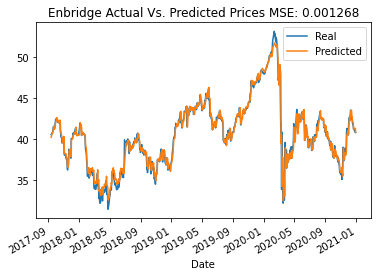

In [24]:
stocks.plot(title=f"Enbridge Actual Vs. Predicted Prices MSE: 0.001268")
plt.savefig('EnbridgeDay.png')

In [25]:
stocks["diff"] = stocks["Real"] - stocks["Predicted"]
stocks["diff"].mean()

-0.05356240095039121

In [26]:
model_json = model.to_json()
file_path = Path("enb_model_1.json")
with open(file_path, "w") as json_file:
    json_file.write(model_json)